# Compute grads and save to file

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from decode_tueg import (
    load_exp, DataScaler, TargetScaler, Augmenter, 
    save_csv, iter_exp_dir, get_freqs_and_info, compute_gradients,
    get_datasets,
)

Tue Feb 14 10:28:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3E:00.0 Off |                  N/A |
| 27%   30C    P8    11W / 250W |   1582MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
batch_size = 128  # TODO: maximize batch size for faster computation
n_jobs = 4
n_recordings = 10
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-09T09:34:21.685021'
checkpoint = 'train_end'

In [3]:
# compute only on valid / eval?
for ds_name in ['transition', 'non_pathological', 'pathological']:
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(f'loading exp {exp_path}')
        clf, data_scaler, target_scaler, config = load_exp(
            exp_dir, exp_path, checkpoint)
        print(f'getting {ds_name}')
        # load preprocessed and windowed dataset
        with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
            ds = pickle.load(f)
        if n_recordings not in [-1, None]:
            ds = ds.split(list(range(n_recordings)))['0']
        print('computing gradients')
        grads = compute_gradients(clf, ds, batch_size, n_jobs)
        # create grads output subdir
        out_path = os.path.join(exp_dir, exp_path, 'grads')
        print(f'saving {out_path}')
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        save_csv(all_grads_df, out_path, f'{checkpoint}_{ds_name}_grads.csv')
        break
    break

loading exp 2023-02-09T09:34:21.685021/20230206/0
getting transition
computing gradients
saving /home/jovyan/experiments/2023-02-09T09:34:21.685021/20230206/0/grads


/tmp/ipykernel_4305/777423640.py:28: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  grads_df = pd.DataFrame(v, index=info.ch_names, columns=freqs)


ValueError: cannot reindex on an axis with duplicate labels

# Read grads from files and plot

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import numpy as np
import pandas as pd
from decode_tueg import (
    plot_band_grads, freqs_to_bin, iter_exp_dir, make_info)

Tue Feb 14 10:56:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3E:00.0 Off |                  N/A |
| 27%   27C    P8     9W / 250W |   1582MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-09T09:34:21.685021'
checkpoint = 'train_end'

In [3]:
bands = [(0,4),(4,8),(8,13),(13,30),(30,50)]

In [7]:
for ds_name in ['longitudinal_transition', 'longitudinal_non_patholotigal', 'longitudinal_pathological']:  # eval
    break

In [5]:
for exp_path in iter_exp_dir(exp_dir, exp_date):
    break

In [6]:
exp_path

'2023-02-07T06:28:03.373666/20230206/0'

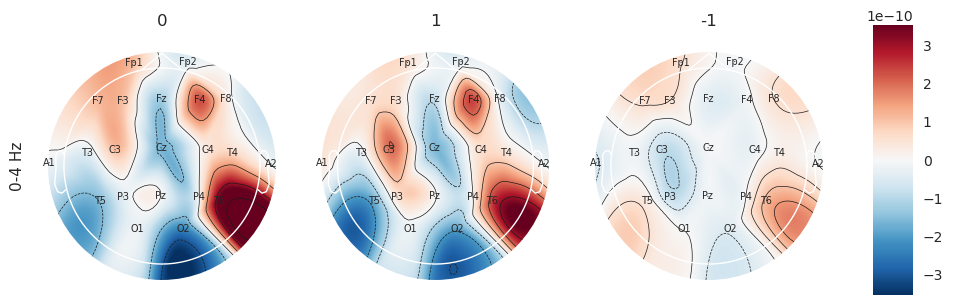

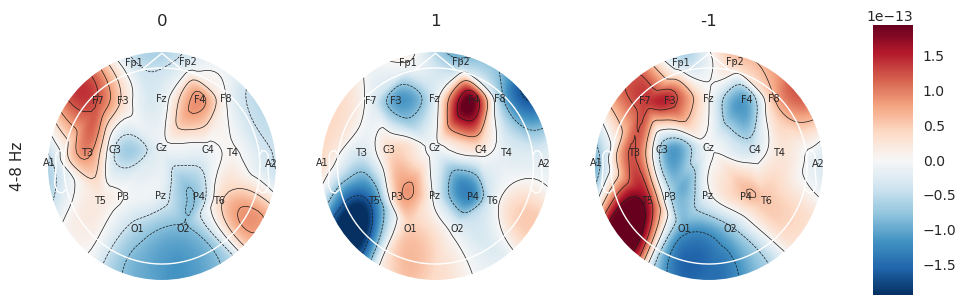

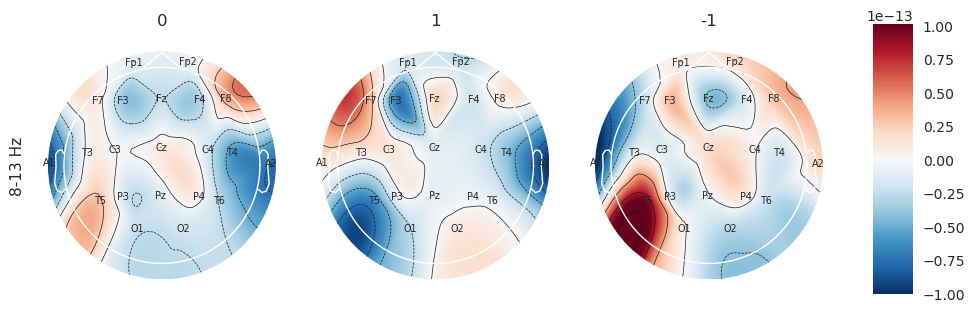

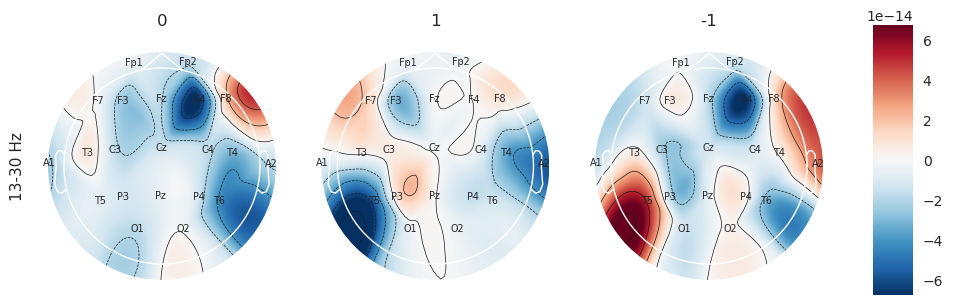

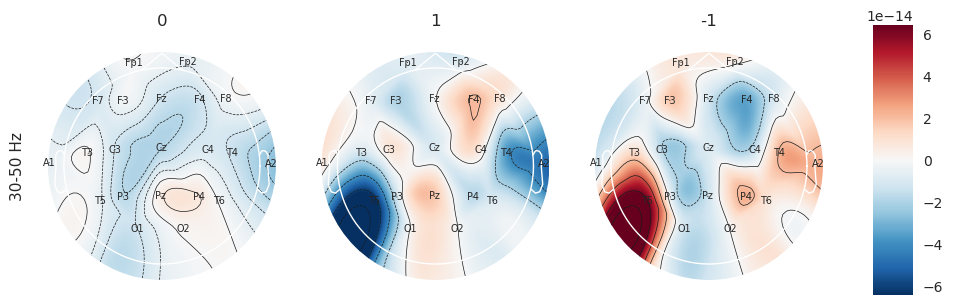

In [10]:
grads = pd.read_csv(os.path.join(exp_dir, exp_path, 'grads', f'{checkpoint}_{ds_name}_grads.csv'), index_col=0)
all_band_grads = {}
for band in bands:
    for pathological, g in grads.groupby('pathological'):
        g.drop('pathological', inplace=True, axis=1)
        names = list(g.index)
        freqs = np.array([float(f) for f in g.columns])
        g = g.values

        l, h = freqs_to_bin(freqs, band)
        band_freqs = freqs[l:h+1]
        band_grads = g[:,l:h+1].mean(axis=1)
        all_band_grads[pathological] = band_grads
    if 0 in all_band_grads.keys() and 1 in all_band_grads.keys():
        all_band_grads[-1] = all_band_grads[0] - all_band_grads[1]
    # TODO: rename again from 0, 1, -1 to patho, non-patho, diff
    fig = plot_band_grads(all_band_grads, make_info(names), band)

In [64]:
for band in bands:
    all_band_grads = {}
    for key, g in grads.items():
        # compute all bands gradients
        l, h = freqs_to_bin(freqs, band)
        band_freqs = freqs[l:h+1]
        band_grads = g[:,l:h+1].mean(axis=1)
        all_band_grads[key] = band_grads        

    fig = plot_band_grads(all_band_grads, info)
    if save:
        fig.savefig()

KeyError: 'key of type tuple not found and not a MultiIndex'